## Speckle Data Pack
### Evaluate Project Room Data
This example explains how to get BIM data from Speckle and convert it table for granular analysis with Pandas and ChatGPT.

In [2]:
%%capture
# capture turns off the output for this cell which would just be the pip install log
%pip install specklepy
%pip install pandas
%pip install pandasai

In [3]:
from specklepy.api.wrapper import StreamWrapper

# Speckle Data Pack project (stream) link
stream_url = "https://speckle.xyz/streams/729cb7c74b"

# wrapper
wrapper = StreamWrapper(stream_url)


In [4]:
from specklepy.api import operations

# get project (stream) data
stream = wrapper.get_client().stream.get(id=wrapper.stream_id, branch_limit=40)

data = []

# models (branches) to skip
exclude_models = ['main', 'all_in_one']

for branch in stream.branches.items:
    
    if branch.commits.items and branch.name not in exclude_models:
        # get obj id from the latest version (commit)
        obj_id = branch.commits.items[0].referencedObject

        # receive objects from speckle
        commit_data = operations.receive(
            obj_id=obj_id, remote_transport=wrapper.get_transport()
        )
        # add data with model (branch) name for reference
        data.append([commit_data, branch.name])
    

In [5]:
# fitler only relevant data points and create table

import pandas as pd

table = {'Name':[], 'Area':[], 'Level':[], 'Model':[]}

# object types to look for
types = ['Rooms']

for item in data: 

    elements = item[0]['elements']

    # get Rooms collection
    for element in elements:
        if element['name'] in types:
            for room in element['elements']:
                # check if level name is not null in case of unplaced rooms
                if room['level'] is not None:
                    table['Level'].append(room['level']['name'])
                    table['Name'].append(room['name'])
                    table['Area'].append(room['area'])
                    # add model name
                    table['Model'].append(item[1])

# create data frame without any null items
df = pd.DataFrame(table)

With table created, we can now slice and dice the room data and look for answers. How many Speckle Lounges are there? What is their total area? How about averige size?

In [6]:
# filter rooms by name

sl = df.loc[df['Name'] == 'Speckle Lounge']
sl_total = sl.loc[:, 'Area'].sum()
sl_average = sl.loc[:, 'Area'].mean()

round(sl_total, 2), round(sl_average,2), len(sl)

(3422.56, 68.45, 50)

Fine grained comparison of all room types with box plot.

<Axes: title={'center': 'Area'}, xlabel='[Name]'>

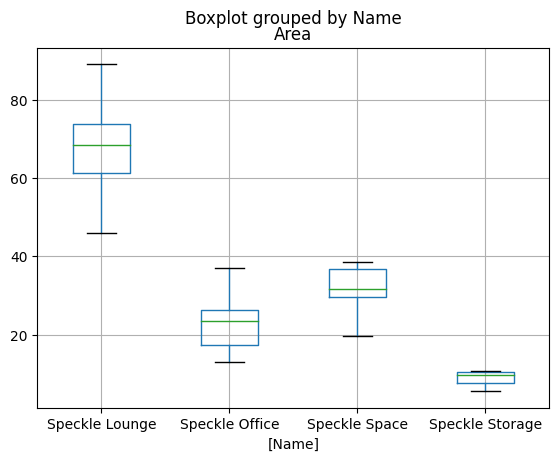

In [7]:
df.boxplot(by='Name')

Total areas per room type.

<Axes: xlabel='Name', ylabel='Total area'>

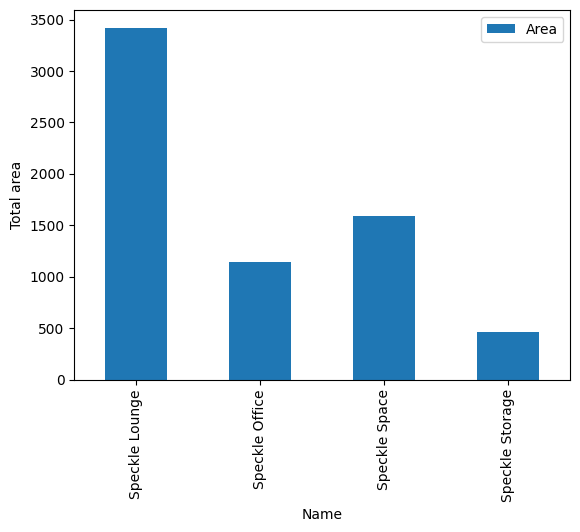

In [8]:
by_name = df.groupby('Name').sum(numeric_only=True)
by_name.plot(kind='bar', ylabel='Total area')

Total room areas for each individual Revit model in the Speckle Data Pack.

<Axes: xlabel='Model', ylabel='Total room area'>

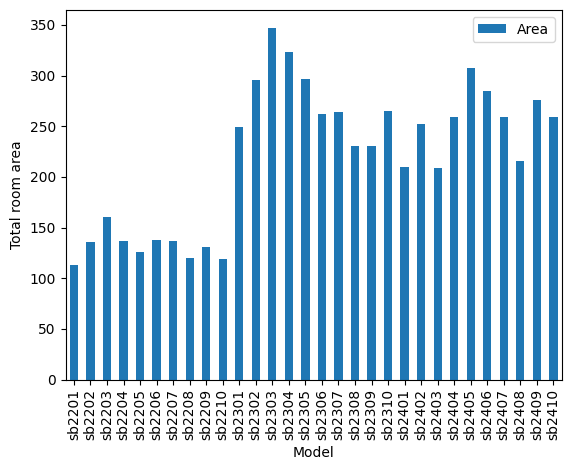

In [9]:
by_model = df.groupby('Model').sum(numeric_only=True)
by_model.plot(kind='bar', ylabel='Total room area')

PandasAI integrates LLMs so you can simply as questions and in this case, ChatGPT will answer.

In [11]:
# load environment variables 
from decouple import config


In [12]:
from pandasai import PandasAI

# Instantiate a LLM
from pandasai.llm.openai import OpenAI
llm = OpenAI(api_token=config('OPENAI_TOKEN'))

pandas_ai = PandasAI(llm)

In [13]:
pandas_ai(df, prompt='Tell me the name and area of the largest space. Also which model and level is it located.')

'The largest space is Speckle Lounge with an area of 89.09399999999998. It is located at Level 0 and the model is sb2303.'

In [14]:
pandas_ai(df, prompt='What levels and models are there?')

'Levels: Level2, Level 0, Level1\nModels: sb2201, sb2202, sb2203, sb2204, sb2205, sb2206, sb2207, sb2208, sb2209, sb2210, sb2301, sb2302, sb2303, sb2304, sb2305, sb2306, sb2307, sb2308, sb2309, sb2310, sb2401, sb2402, sb2403, sb2404, sb2405, sb2406, sb2407, sb2408, sb2409, sb2410'